In [1]:
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
import pandas as pd

Connecting austin@datajoint.internationalbrainlab.org:3306


In [2]:
from psychofit import psychofit as psy

In [3]:
from behavior_plots import *

In [4]:
from load_mouse_data import *

Connected to https://alyx.internationalbrainlab.org as vathes


In [5]:
ibl17 = (subject.Subject() & 'subject_nickname = "IBL_17"').fetch1()

## Weight over time

In [6]:
wei = {}
wei['date_time'], wei['weight'] = (action.Weighing() & ibl17).fetch('weighing_time', 'weight', order_by='weighing_time')

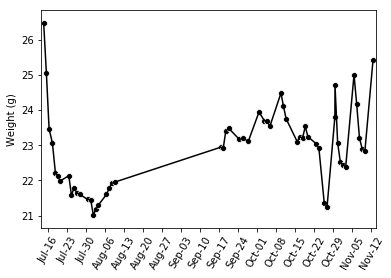

In [7]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="date_time", y="weight", color="black", markers=True, data=wei, ax=ax)
sns.scatterplot(x="date_time", y="weight", color="black", data=wei, ax=ax)
ax.set(xlabel='', ylabel="Weight (g)", 
xlim=[wei['date_time'].min()-timedelta(days=1), wei['date_time'].max()+timedelta(days=1)])
fix_date_axis(ax)

## Water intake

In [8]:
def dj_get_water(mouse):
    w = (action.WaterAdministration() & mouse).fetch(as_dict=True)
    w = pd.DataFrame(w)
    w.rename(columns={'administration_time':'date_time'}, inplace=True)
    w['date_time'] = pd.to_datetime(w.date_time)
    w.sort_values('date_time', inplace=True)
    w.reset_index(drop=True, inplace=True)
    w['date'] = w['date_time'].dt.floor('D')
    w['days'] = w.date - w.date[0]
    w['days'] = w.days.dt.days
    w = w.set_index('date')
    w.index = pd.to_datetime(w.index)
    wa_unstacked = w.pivot_table(index='date', 
        columns='watertype_name', values='water_administered', aggfunc='sum').reset_index()
    wa_unstacked['date'] = pd.to_datetime(wa_unstacked.date)
    wa_unstacked.set_index('date', inplace=True)
    return wa_unstacked, w

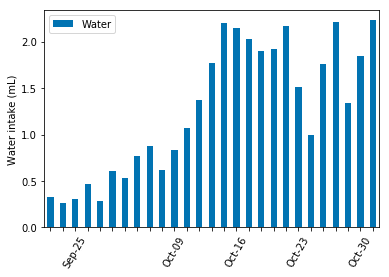

In [9]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.set_palette("colorblind") # palette for water
wa_unstacked, wa = dj_get_water(ibl17)
wa_unstacked.loc[:,['Water']].plot.bar(stacked=True, ax=ax)
l = ax.legend()
l.set_title('')
ax.set(ylabel="Water intake (mL)", xlabel='')

# fix dates, known to be an issue in pandas/matplotlib
ax.set_xticklabels([dt.strftime('%b-%d') if dt.weekday() is 1 else "" for dt in wa_unstacked.index.to_pydatetime()])
for item in ax.get_xticklabels():
    item.set_rotation(60)

## Performance on easy trials

In [10]:
def dj_get_behavior(mouse):
    b = behavior.TrialSet.Trial & mouse
    behav = pd.DataFrame(b.fetch(order_by='session_start_time'))
    behav['session_start_time'] = pd.to_datetime(behav.session_start_time)
    behav['date']       = behav['session_start_time'].dt.floor("D")
    behav['signedContrast'] = (behav['trial_stim_contrast_left'] - behav['trial_stim_contrast_right']) * 100
    behav['signedContrast'] = behav.signedContrast.astype(int)
    val_map = {'CCW': -1, 'No Go': 0, 'CW': 1}
    behav['choice'] = behav['trial_choice'].map(val_map)
    behav['correct']   = np.where(np.sign(behav['signedContrast']) == behav['choice'], 1, 0)
    behav.loc[behav['signedContrast'] == 0, 'correct'] = np.NaN
    behav['choice2'] = behav.choice.replace([-1, 0, 1], [0, np.nan, 1]) # code as 0, 100 for percentages
    behav['correct_easy'] = behav.correct
    behav.loc[np.abs(behav['signedContrast']) < 50, 'correct_easy'] = np.NaN
    return behav

In [11]:
behav = dj_get_behavior(ibl17)
correct_easy = behav.groupby(['session_start_time'])['correct_easy'].mean().reset_index()
trialcounts = behav.groupby(['session_start_time'])['trial_id'].max().reset_index()

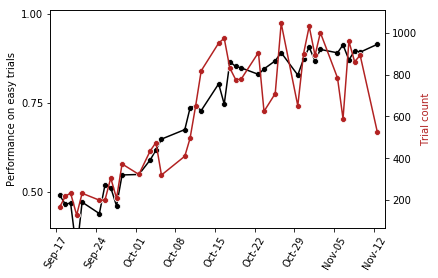

In [12]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="session_start_time", y="correct_easy", markers=True, color="black", data=correct_easy, ax=ax)
sns.scatterplot(x="session_start_time", y="correct_easy", color="black", data=correct_easy, ax=ax)
ax.set(xlabel='', ylabel="Performance on easy trials", 
    xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=2)],
    yticks=[0.5, 0.75, 1], ylim=[0.4, 1.01])
ax.yaxis.label.set_color("black")
righty = ax.twinx()
sns.lineplot(x="session_start_time", y="trial_id", markers=True, color="firebrick", data=trialcounts, ax=righty)
sns.scatterplot(x="session_start_time", y="trial_id", color="firebrick", data=trialcounts, ax=righty)
righty.yaxis.label.set_color("firebrick")
righty.grid(False)
fix_date_axis(righty)
fix_date_axis(ax)
righty.set(xlabel='', ylabel="Trial count", 
xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=2)])
fix_date_axis(ax)

## Contrast/choice heatmap

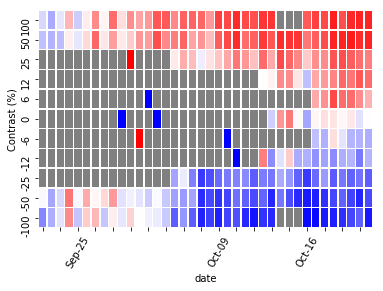

In [13]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plot_perf_heatmap(behav, ax=ax)
ax.set_xticklabels([dt.strftime('%b-%d') if dt.weekday() is 1 else "" for dt in wa_unstacked.index.to_pydatetime()])
for item in ax.get_xticklabels():
    item.set_rotation(60)